In [1]:
import os


import pathlib
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import IPython
import seaborn as sns
import sklearn.metrics as metrics
sns.set_style("darkgrid")

from tqdm import tqdm  
from CAWR import CosineAnnealingWarmUpRestarts


from Residual_Attention import ResAtt
model = ResAtt(1, 2)


loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-8)

epochs = 100
lr_scheduler = CosineAnnealingWarmUpRestarts(
        optimizer = optimizer, 
        T_0 = epochs // 4, 
        T_mult = 1, 
        eta_max = 1e-4, 
        T_up = 2, 
        gamma = .5)

2023-12-20 03:08:53.813809: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using TensorFlow backend.


In [2]:

day1_list = [str(i) for i in pathlib.Path(f'./Socialtask_raw_E4_231110/Day1/').glob('*/*BVP.csv')]
day2_list = [str(i) for i in pathlib.Path(f'./Socialtask_raw_E4_231110/Day2/').glob('*/*BVP.csv')]

survey = pd.read_excel('./Survey_n71.xlsx')
survey = survey[['SubjectID', 'PHQ9']]
print(len(day1_list), len(day2_list), len(survey))


70 70 71


In [3]:
day1_hrv_indices = pd.read_csv('Day1_HRV_IndexInfo.csv')
print(len(day1_hrv_indices)//2)
print(len(day1_hrv_indices['SubjectID'].unique()))
day1_hrv_indices = day1_hrv_indices.drop_duplicates('SubjectID')


day2_hrv_indices = pd.read_csv('Day2_HRV_IndexInfo.csv')
print(len(day2_hrv_indices)//2)
print(len(day2_hrv_indices['SubjectID'].unique()))
day2_hrv_indices = day2_hrv_indices.drop_duplicates('SubjectID')

68
68
68
68


In [4]:
day1_df = pd.DataFrame(day1_list, columns = ['day1'])
day1_df['subject'] = day1_df['day1'].apply(lambda x : x.split('/')[2])
print(len(day1_df['subject'].unique()))

day2_df = pd.DataFrame(day2_list, columns = ['day2'])
day2_df['subject'] = day2_df['day2'].apply(lambda x : x.split('/')[2])
print(len(day2_df['subject'].unique()))

70
70


In [5]:
day1_df = day1_df.merge(day1_hrv_indices, left_on = 'subject', right_on = 'SubjectID', how = 'inner')
day2_df = day2_df.merge(day2_hrv_indices, left_on = 'subject', right_on = 'SubjectID', how = 'inner')



In [6]:
day1_df = day1_df[['day1', 'subject', 'start', 'end']]
day1_df.columns = ['path', 'subject', 'start', 'end']
day1_df = day1_df.merge(survey, left_on = 'subject', right_on = 'SubjectID', how = 'inner').drop(columns = ['SubjectID'])


day2_df = day2_df[['day2', 'subject', 'start', 'end']]
day2_df.columns = ['path', 'subject', 'start', 'end']
day2_df = day2_df.merge(survey, left_on = 'subject', right_on = 'SubjectID', how = 'inner').drop(columns = ['SubjectID'])

In [7]:
day1_df['subject'] = day1_df['subject'].apply(lambda x : 'day1_' + x)
day2_df['subject'] = day2_df['subject'].apply(lambda x : 'day2_' + x)


In [8]:
master_df = pd.concat([day1_df, day2_df])

In [9]:
master_df['len'] = master_df['path'].apply(lambda x : len(pd.read_csv(x)))

def cal(row):
    return row['end'] - row['start']

master_df['duration'] = master_df.apply(cal, axis = 1)

<AxesSubplot:>

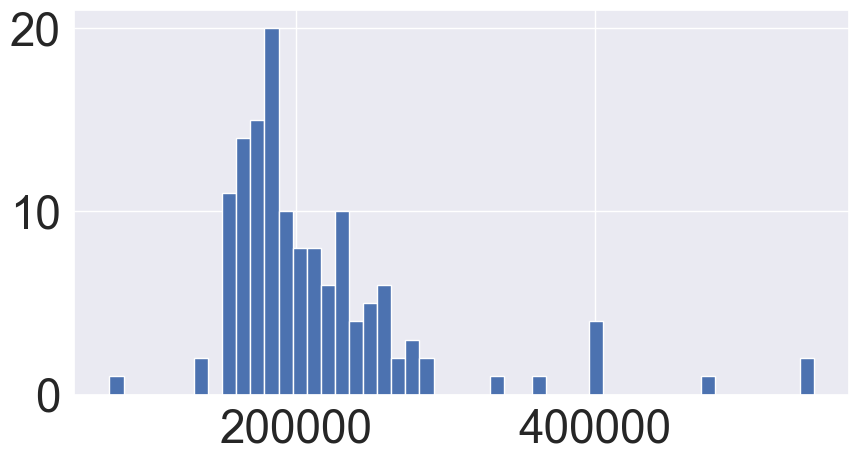

In [10]:
sns.set(font_scale=3)
master_df['len'].hist(figsize = (10, 5), bins = 50)

<AxesSubplot:>

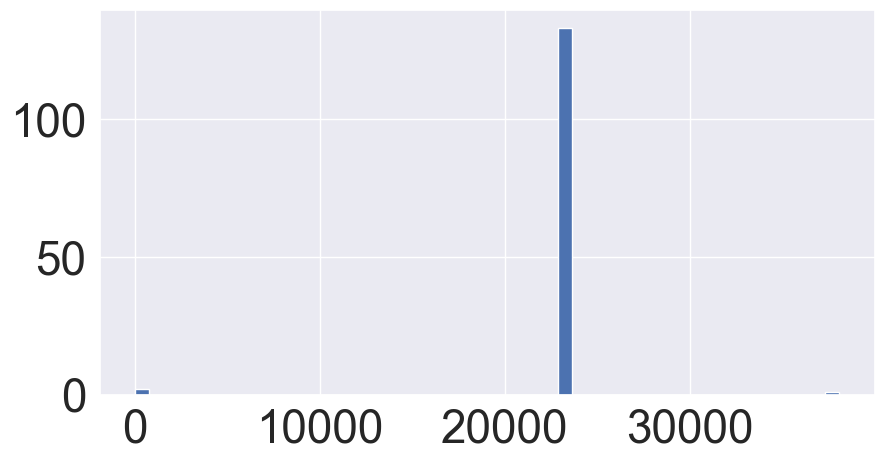

In [11]:
master_df['duration'].hist(figsize = (10, 5), bins = 50)

In [12]:
master_df = master_df[master_df['duration'] > 1000]

<AxesSubplot:>

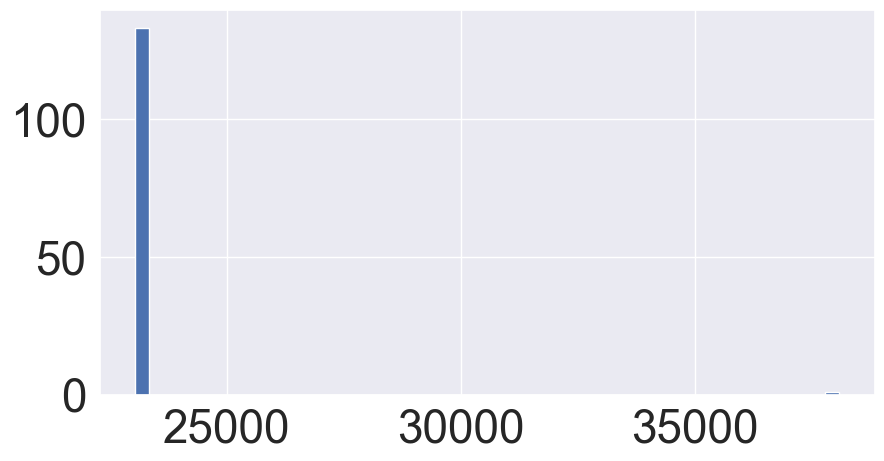

In [13]:
master_df['duration'].hist(figsize = (10, 5), bins = 50)

<AxesSubplot:>

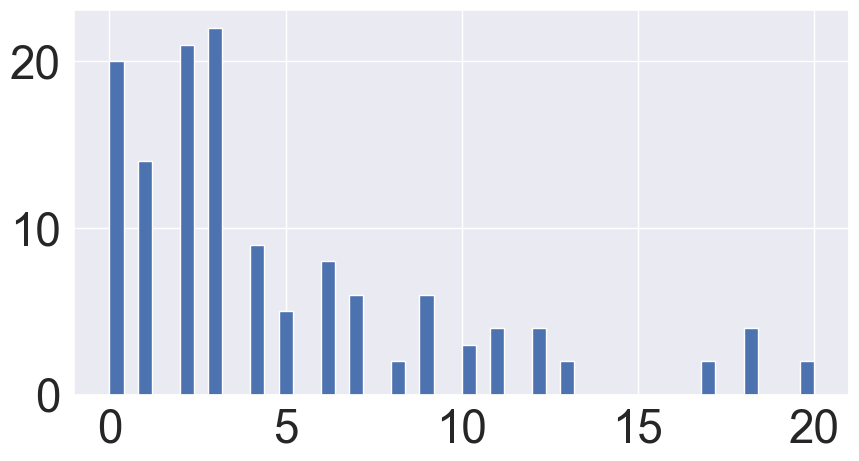

In [14]:
master_df['PHQ9'].hist(figsize = (10, 5), bins = 50)

<AxesSubplot:>

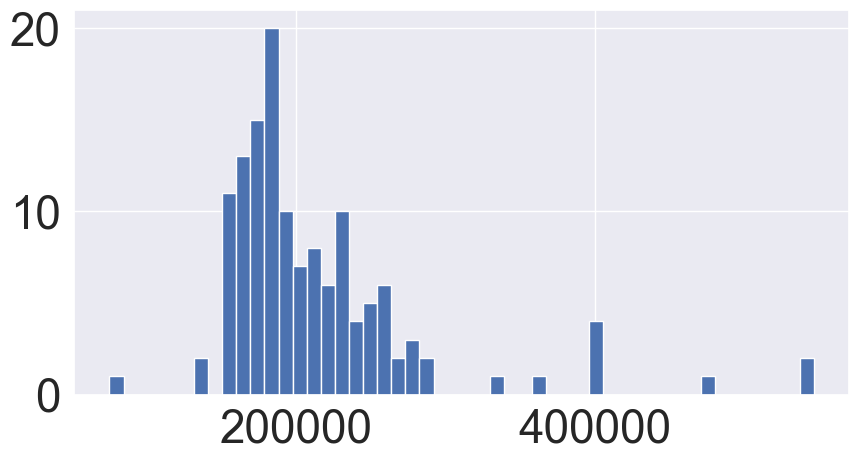

In [15]:
sns.set(font_scale=3)
master_df['len'].hist(figsize = (10, 5), bins = 50)

In [16]:
master_df = master_df[master_df['len'] > 100000]

In [17]:
print(sum(master_df['PHQ9']<10))
print(sum(master_df['PHQ9']>=10))

113
20


In [18]:
normal_list = master_df[master_df['PHQ9']<10]['subject'].tolist()
mdd_list = master_df[master_df['PHQ9']>=10]['subject'].tolist()

random.seed(2)

test_list = list()
test_list += random.sample(normal_list, 25)
test_list += random.sample(mdd_list, 5)


In [19]:
test_df = master_df[master_df['subject'].isin(test_list)]
print(len(test_df))

train_df = master_df[~master_df['subject'].isin(test_list)]
print(len(train_df))

30
103


In [20]:
class data_set(torch.utils.data.Dataset):
    def __init__(self, df, resting = True, train = True, train_window = 19_200):
        self.df = df.reset_index().drop(columns = ['index'])
        self.resting = resting
        self.train = train
        self.train_window = train_window

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        PPG = pd.read_csv(self.df.iloc[index]['path'])
        
        if self.resting:
            start = self.df.iloc[index]['start']
            end = self.df.iloc[index]['end']
            PPG = PPG.iloc[start : end].reset_index().drop(columns = ['index'])

            if self.train:
                duration = end - start
                remain = duration - self.train_window
                new_start = random.randint(0, remain - 1)
                PPG = PPG.iloc[new_start : new_start + self.train_window]
                
        elif not self.resting:
            if self.train:
                new_start = random.randint(0, len(PPG)-40000)
                end = new_start + 40000
                PPG = PPG.iloc[new_start : new_start + 40000]
                
        PPG = (PPG - PPG.mean()) / PPG.std()

        label = self.df.iloc[index]['PHQ9'] >= 5

        return torch.tensor(PPG.to_numpy()).reshape(1, -1).to(torch.float32), torch.tensor(label*1).long()


In [21]:
train_loader = torch.utils.data.DataLoader(
    dataset = data_set(train_df.iloc[:1], resting = False),
    batch_size = 4,
    # pin_memory = True,
    # num_workers = 4,
    shuffle = False,
)

test_loader = torch.utils.data.DataLoader(
    dataset = data_set(test_df.iloc[:1], train = False, train_window = -1, resting = False),
    batch_size = 1,
    # pin_memory = True,
    # num_workers = 4,
    shuffle = False,
)

In [22]:
for data in train_loader:break
data[0][0,0].shape

torch.Size([40000])

In [23]:
def train(train_loader, model, optimizer, loss_function, tqdm = False):
    model.train()
    # f1 구해야 해서 한번에 하는게 맞다.
    label_list = list()
    output_list = list()
    
    if tqdm:
        train_loader = tqdm(train_loader)
        
    for ppg, label in train_loader:
        # output = model(ppg.cuda())
        output = model(ppg)
        # loss = loss_function(output, label.cuda())
        loss = loss_function(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        label_list.append(label)
        output_list.append(output.detach().cpu())
        
    output = torch.vstack(output_list)
    label = torch.hstack(label_list)

    return output, label
        

@torch.no_grad()
def evaluate(eval_loader, model):
    model.eval()
    label_list = list()
    output_list = list()

    for physio, label in eval_loader:
        # output = model(physio.cuda())
        output = model(physio)

        label_list.append(label)
        output_list.append(output.detach().cpu())

    output = torch.vstack(output_list)
    label = torch.hstack(label_list)

    return output, label


def metric_function(output : torch.tensor, target : torch.tensor):
    '''
    batch = mini batch or full batch
    output : (batch, class) : dosent matter after softmax or not
    target : (batch, )
    '''
    output = torch.softmax(output, dim = 1)
    pred = torch.argmax(output, dim = 1)

    conf_matrix = metrics.confusion_matrix(target, pred) # np.array
    accuracy = conf_matrix.diagonal().sum() / conf_matrix.sum()
    return {'accuracy' : accuracy, 'conf_matrix' : conf_matrix}


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

        

In [ ]:
sns.set(font_scale=2)
total_result = dict()

# random guess
output, label = evaluate(test_loader, model)
test_result = {'accuracy' : metric_function(output, label)['accuracy']}
test_result.update({'loss' : loss_function(output, label).cpu()})
test_result = {f'test {key}' : value for key, value in test_result.copy().items()}
total_result[0] = test_result

for epoch in tqdm(range(1, epochs + 1)):
    output, label = train(train_loader, model, optimizer, loss_function)
    print(metric_function(output, label)['conf_matrix'])
    train_result = {'accuracy' : metric_function(output, label)['accuracy']}
    train_result.update({'loss' : loss_function(output, label).cpu()})
    result_dict = {f'train {key}' : value for key, value in train_result.items()}

    output, label = evaluate(test_loader, model)
    print(metric_function(output, label)['conf_matrix'])
    test_result = {'accuracy' : metric_function(output, label)['accuracy']}
    test_result.update({'loss' : loss_function(output, label).cpu()})
    test_result = {f'test {key}' : value for key, value in test_result.copy().items()}
    result_dict.update(test_result)
    result_dict.update({'learning rate' : get_lr(optimizer)})

    total_result[epoch] = result_dict
    lr_scheduler.step()

    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(20,6))



    # Extracting train and test accuracies
    train_accuracies = [value.get('train accuracy', None) for key, value in total_result.items()]
    test_accuracies = [value.get('test accuracy', None) for key, value in total_result.items()]
    # Plotting the accuracies
    plt.subplot(1,3,1)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(test_accuracies, label='Test Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy')
    plt.legend()
    plt.grid(True)

    # Extracting train and test accuracies
    train_loss = [value.get('train loss', None) for key, value in total_result.items()]
    test_loss = [value.get('test loss', None) for key, value in total_result.items()]
    # Plotting the loss
    plt.subplot(1,3,2)
    plt.plot(train_loss, label='Train loss', marker='o')
    plt.plot(test_loss, label='Test loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title('Train and Test loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1,3,3)
    lr = [value.get('learning rate', None) for key, value in total_result.items()]
    plt.plot(lr, label='learning rate', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('lr')
    plt.title('Learning Rate')
    plt.legend()
    plt.grid(True)

    plt.show()
    print(metric_function(output, label)['conf_matrix'])


  0% 0/100 [00:00<?, ?it/s]

[[2 3]
 [2 3]]


In [ ]:
print(metric_function(output, label)['conf_matrix'])